In [1]:
#Import all the dependencies

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import numpy as np

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from math_functions import *
from Obstacle import *

# Bug2 Algorithm

## Helper functions
This are the helper functions used by Bug2 when looking for a path to start and goal locations:

- ``is_about_to_hit_obstacle(.)``, this method searches for the obstacle that is the closest to the robot and verifies whether the robot's touch sensor has been activated. This method depends on ``find_closest_obstacle(.)``.

- ``go_back_to_goal(.)``, this method determines whether the robot should stop circumnavigating the obstacle and move towards the goal instead.

- ``has_reached_goal(.)``, this method tells us whether the robot has reached the goal

- ``move_towards_goal(.)``, this method moves the robot along the line that connects the start and goal positions

In [2]:
# Helper functions
def find_closest_obstacle(position, obstacle_list):
    results = [obs.compute_distance_point_to_polygon(position) for obs in obstacle_list]
    closest_obs = np.argmin([v[0] for v in results])
    return obstacles[closest_obs], results[closest_obs]

def has_reached_goal(current_pos, goal, step_size):
    if compute_distance_between_points(current_pos, goal) > step_size:
        return False
    return True

def move_towards_goal(current_pos, goal_line, step_size):
    direction_to_goal = get_direction_from_line(goal_line)
    next_position = current_pos + step_size * direction_to_goal
    return next_position


def is_about_to_hit_obstacle(next_pos, obstacle_list, step_size):
    _, (closest_obs_distance, obst_segment) = find_closest_obstacle(next_pos, obstacle_list)
    if closest_obs_distance < step_size:
        return True
    return False

def go_back_to_goal(next_pos, goal_pos, start_to_goal_line, distance_to_hit_point, step_size):
    a, b, c = start_to_goal_line
    dist_to_robot_goal_line = np.abs(a*next_pos[0] + b*next_pos[1] - c)/math.sqrt(a*a + b*b)
    new_dist_to_goal = compute_distance_between_points(next_pos, goal_pos)
    stop_following_obstacle = (dist_to_robot_goal_line <= step_size) and (new_dist_to_goal < distance_to_hit_point)
    return stop_following_obstacle

## Main Algorithm

Below we show the implementation of the Bug2 Algorithm. This implementation is based on the pseudocode presented in the lecture

![title](Support/images/bug2.png)

In [7]:
# Set parameters

# Order A
goal_pos = [20.0, 10.0]
initial_robot_pos = [30.0, 40.0]
robot_step_size = 0.5

# # # Uncomment the next two lines to see the bug algorithm in reverse order
# # Order B
goal_pos = [30.0, 40.0]
initial_robot_pos = [20.0, 10.0]
robot_step_size = 0.5

# ---------------------------------- Parameters associated to 2nd FLUX Question ----------------------
# initial_robot_pos = [25.0, 5.0]
# goal_pos = [25.0, 40.0]  
# robot_step_size = 0.5

# # Create obstacles
# obstacle3 = Polygon(vertices= np.array([[10, 20], [35, 20], [35, 50], [15, 50],
#                                        [15, 35], [28, 35], [28, 30], [10, 30],
#                                        [10, 55], [40, 55], [40, 15], [10, 15]]))
# obstacles = [obstacle3]

# ----------------------------------------------------------------------------------------------------

obstacle1 = Rectangle(origin=np.array([10, 20]), width=30, height=5)
obstacle2 = Polygon(vertices= np.array([[20, 35], [35, 35], [35, 50], [40, 50],
                                       [40, 30], [20, 30]]))
obstacles = [obstacle1, obstacle2]

    
# Start algorithm
robot_path = [initial_robot_pos]
current_robot_pos = initial_robot_pos
robot_to_goal_line = compute_line_through_points(current_robot_pos, goal_pos)
initial_dist_to_goal = compute_distance_between_points(initial_robot_pos, goal_pos)

# While goal not reached
i = 0
while not has_reached_goal(current_robot_pos, goal_pos, robot_step_size) and i < 200:
   
    # Move towards goal
    next_robot_pos = move_towards_goal(current_robot_pos, robot_to_goal_line, robot_step_size)
    
    if is_about_to_hit_obstacle(next_robot_pos, obstacles, robot_step_size):
        
        # Go back to current position
        next_robot_pos = np.copy(current_robot_pos)
        # Compute distance from hit point to goal
        hit_dist_to_goal = compute_distance_between_points(current_robot_pos, goal_pos)
        
        while True:
            # Find nearest_obstacle and start navigating around 
            closest_obs, (closest_obs_distance, obst_segment) = find_closest_obstacle(next_robot_pos,
                                                                                     obstacles)
            # Get direction along obstacle
            direction_around_obstacle = closest_obs.compute_tangent_vector_to_polygon(next_robot_pos, 
                                                                                      obst_segment)
            # Move along obstacle
            next_robot_pos = next_robot_pos + robot_step_size * direction_around_obstacle

            robot_path.append(next_robot_pos)

            # Stop getting around obstacle when:
            # * we are back to the original line and
            # * we are closer to the goal than when we started getting around obstacle
            stop_getting_around = go_back_to_goal(next_robot_pos, goal_pos,
                                                  robot_to_goal_line, hit_dist_to_goal, robot_step_size)
            
            if stop_getting_around:
                break
    
    # Update current state and add to path
    current_robot_pos = next_robot_pos
    robot_path.append(current_robot_pos)
    

## Bug2 in Execution

Let's see the Bug2 algorithm in execution. We consider two cases:

- Two obstacles
- Two obstacles with reversed start and goal locations (manually switch the definition of the start and goal locations)
- A continuos obstacle (see picture in second FLUX question)

**Interaction**:
- Swap start and goal location as well as the obstacles. Re-run the previous cell and observe the paths generated for both cases. Is the robot moving on left or the right?

<IPython.core.display.Javascript object>


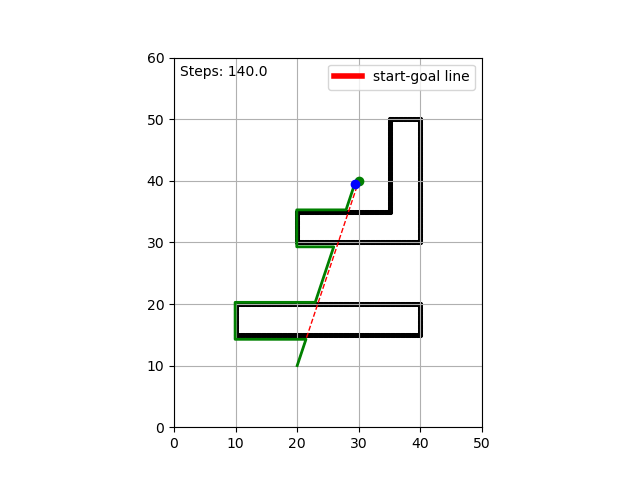

In [8]:
def plot_obstacles(obstacles, ax):
    for obs in obstacles:
        ox, oy = obs.plot_obstacle()
        ax.scatter(ox, oy, s=7, c='k')

# Set plot variables
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, 50), ylim=(0, 60))
ax.grid()

goal, = ax.plot([], [], 'o', lw=2, c='g')
line, = ax.plot([], [], 'r--', lw=1)
path_line, = ax.plot([], [], 'g', lw=2)
robot, = ax.plot([], [], 'ob', lw=4)
steps_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
custom_lines = [Line2D([0], [0], color='r', lw=4)]
ax.legend(custom_lines, ['start-goal line'])

plot_obstacles(obstacles, ax)

s_x, s_y = initial_robot_pos
g_x, g_y = goal_pos

plan = np.array(robot_path)

if plan is not None:
    # Animation code
    def init():
        goal.set_data(g_x, g_y)
        robot.set_data(s_x, s_y)
        path_line.set_data(s_x, s_y)
        steps_text.set_text('')
        line.set_data([s_x, g_x], [s_y, g_y])
        return robot, goal, path_line, steps_text

    def animate(i):
        """perform animation step"""
        pos = plan[i,:]
        robot.set_data(pos[0], pos[1])
        path_line.set_data(plan[:i, 0], plan[:i, 1])
        steps_text.set_text('Steps: %.1f' % i)
        return robot, path_line

    ani = animation.FuncAnimation(fig, animate, frames=700, blit=True, interval=10, init_func=init)
    
else:
    print("Path was not found!!")


**FLUX Question (1 pt)**: How many steps did it take the robot to move from start = $(20,10)$ to end =$(30, 40)$ (order A) and from start = $(30, 40)$ to end = $(20,10)$ (order B)?

**Answer: from start = (20,10)  to end = (30,40): 141**

**from start =  (30,40)  to end = (20,10) : 239**

**FLUX Question (1 pt)**: Given the environment shown below and after seeing how our implementation of bug2 works, do you think that our implementation will succeed or fail to find a path from the start (red dot) to the goal (green dot) locations?

**Answer: Success**

![title](Support/images/Bug2Question.png)